## DOE ARM SGP 30QCECOR Analysis 
### CO$_2$ and latent heat flux analysis as a function of surface conditions (vegetation type, etc.) reported in ARM Preventative Maintenance (PM) reports 

##### Written by Sid Gupta (sid.gupta@anl.gov) - last updated September, 2025
- Reviewed by Adam Theisen for upload to ARM-FLUX-VEG repository.
  
The authors acknowledge the contributions of the site operations staff for their dedicated efforts in manually collecting and curating vegetation information. These measurements were integral to the development and production of this data product.

#### Introduction

This notebook deals with Eddy Correlation Flux Measurement System (ECOR) data from the ARM Southern Great Plains (SGP) facility sites. Preventative Maintenance (PM) reports provide site operator responses to preset questions about vegetation and surface conditions. These responses can supplement the ECOR measurements to provide ground truth. These responses can be subjective, and thus they are provided here in place of an ARM datastream. 

Data from old PM reports until 2020 were compiled into a single file. The notebook describes how data from the biweekly PM reports can be used along with the ECOR datastream. Please see the instrument webpage for the Eddy Correlation Flux Measurement System (ECOR) (https://www.arm.gov/capabilities/instruments/ecor). In October 2019, the ECOR systems at SGP were upgraded with newer-model instruments, including the addition of a microprocessor allowing both uncorrected and corrected fluxes in a single datastream, ECORSF. A separate notebook is provided for using the ECORSF datastream. 

Uncorrected turbulent fluxes are available in the 30ecor datastream. It is recommended that routine ECOR corrections are applied to the data prior to use, and corrected fluxes are available in the 30qcecor VAP. This notebook deals with data from the quality controlled VAP (30QCECOR), surface/vegetation conditions from the PM reports, and wind direction from the 30ECOR datastream to apply wind direction checks (see handbook). In the 30ECOR datastream, there were known issues with the CO$_2$ flux measurements but this notebook addresses both CO$_2$ and latent heat fluxes.

Notes:
- S4, S5, and S6 were only deployed temporarily for the AWAKEN field campaign - there are not too many PM reports for these sites after the campaign. 
- PM reports are provided biweekly, and it is assumed surface conditions did not vary considerably over the two week period. With this assumption, ECOR data from the preceding two weeks can be associated with the PM report. Thus, one can analyze flux measurements as a function of vegetation type, condition, color, etc.
- This notebook helps identify sites with most PM reports; commonly reported crop types and surface conditions, etc. The notebook provides examples for plots of trends in CO$_2$ or latent heat fluxes as a function of the crop types and vegetation/soil conditions.

#### Notebook Contents
- Find most frequently reported vegetation conditions
- Calculate flux by vegetation type
- Retrieve ECOR data for the timings associated with these conditions
- Find variability in flux data based on variable conditions within these timings


In [1]:
import act
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import glob

C:\Users\sid.gupta\AppData\Local\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\sid.gupta\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\sid.gupta\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


## NEED TO FIX THE VARIABLES THAT ARE MESSED UP (LIKE ECVT1 FOREST COVERED, ECVT2)

### Load PM reports data

In [2]:
sfccond=pd.read_excel('SGP_Surface_Conditions.xlsx')
sfccond.keys()

Index(['Timeon', 'Sitename', 'Date', 'Name', 'tvlA', 'tvlB', 'tvlC', 'tvlD',
       'tvlE', 'hinside', 'houtside', 'ecunan', 'pasrg', 'ecvt2', 'ecvt1',
       'mbs', 'wwh', 'wwhlst', 'rcrp', 'rctyp', 'rctyp1', 'ecvcon', 'ecsoil',
       'ecmoist', 'echt', 'vhifmos', 'vhofmos', 'Comments'],
      dtype='object')

Variable long names (along with most common responses):

- Name - Technician name
- tvlA - Type of vegetation (Mostly clumped grass, Mostly uniform grass)
- tvlB - Type of vegetation (Derived from grazed grasslands, Native prairie) 
- tvlC - Vegetation condition ('Brown due to freezing conditions', 'Lush green, unwilted', 'Green w/brown patches because of hot, dry weather', 'Mostly brown due to hot, dry weather','Fully green but noticeably wilted')
- tvlD - Surface soil conditions ('Dry and dusty', 'Moist but not muddy', 'Muddy or standing water')
- tvlE - Moisture on vegetation (or soil if no vegetation) ('Dry', 'Slightly wet because of rain or dew', 'Mostly wet because of rain or dew')
- hinside - Approximate height of vegetation inside fence
- houtside - Approximate height of vegetation outside but near fence


Only for sites with Eddy Correlation (EC) stations:
- ecunan - Unanticipated vegetation condition (mostly No)
- pasrg - Pasture or rangeland (No: 3943, Yes: 922)
- ecvt2 - Type of vegetation ('Derived from grazed grasslands', 'Native prairie', 'Forest Covered')
- ecvt1 - Type of vegetation ('Mostly clumped grass', 'Mostly uniform grass', 'Forest Covered', 'Woods') 
- mbs - Mostly bare soil (Yes, No)
- wwh - Winter wheat (Yes, No)
- wwhlst - Winter wheat condition ('Green, ground covered','Partial soil coverage because plants are small','Stubble after harvest','Stubble mostly covered with green weeds after harvest','Yellow but unharvested')
- rcrp - Row crops (Yes, No)
- rctyp - Row crop type ('Alfalfa', 'Soybeans', 'Corn', 'Other Row Crop (see comments)','Sorghum', 'Milo')
- rctyp1 - Row crop type ('Green, ground covered', 'Only debris left after harvest','Yellow but unharvested', 'Partial soil coverage because plants small')
- ecvcon - Vegetation condition ('Lush green, unwilted', 'Brown due to freezing conditions','All or mostly bare soil', 'Mostly brown due to hot, dry weather','Green with brown patches because of hot, dry weather','Fully green but noticeably wilted')
- ecsoil - Surface soil conditions ('Dry and dusty', 'Moist but not muddy', 'Muddy or standing water')
- ecmoist - Moisture on vegetation or soil ('Dry', 'Slightly wet because of rain or dew', 'Mostly wet because of rain or dew', '0-25% snow covered')
- echt - Approximate height of vegetation

Only at extended facilities with EBBR stations

- vhifmos - Vegetation inside fence is mostly (Grassy, Broadleaf)
- vhofmos - Vegetation outside fence is mostly (Grassy, Broadleaf)

#### Identify the most commonly reported sites where crops are reported and identify crop type

In [3]:
# sfccond['Sitename'].value_counts() # Identify most commonly reported sites

sfccond[['rctyp','Sitename']].value_counts()[0:20]

rctyp                          Sitename    
Alfalfa                        E6 Towanda      178
                               E14 CF          119
Soybeans                       E3 LeRoy        107
                               E33 Newkirk     104
Alfalfa                        E10 Tyro         65
Sorghum                        E5 Halstead      64
Soybeans                       E31 Anthony      55
Corn                           E31 Anthony      55
                               E3 LeRoy         53
                               E33 Newkirk      42
Soybeans                       E39 Morrison     39
Milo                           E31 Anthony      37
Soybeans                       E5 Halstead      30
Corn                           E14 CF           29
Other Row Crop (see comments)  E3 LeRoy         26
                               E1 Larned        18
                               E31 Anthony      12
Corn                           E5 Halstead      12
Other Row Crop (see comments)  E5 Hals

In [4]:
# We can define a subset of the data when the 'row crop' field was set to 'Yes', indicating the presence of crops
site_conditions_all=sfccond[sfccond['rcrp']=='Yes']

site_conditions_all['Sitename'].value_counts()[0:6]

Sitename
E3 LeRoy       200
E6 Towanda     178
E31 Anthony    163
E14 CF         151
E33 Newkirk    143
E5 Halstead    112
Name: count, dtype: int64

In [5]:
# site_conditions=sfccond[(sfccond['Sitename']=='E3 LeRoy') & (sfccond['rcrp']=='Yes')]

### Download QCECOR VAP (30QCECOR) data for two weeks leading up to each PM report
- Also downloading the 30ECOR datastream to get the wind direction for the fetch and applying the wind direction check (see below for details).

In [6]:
# Data are downloaded using the DOE ACT software package (see https://arm-doe.github.io/ACT/API/generated/act.discovery.download_arm_data.html)

# Set your ARM Live data username and password (see instructions on ACT link above)
username = ''
token = ''

In [8]:
# Mention a single site from the list
# Downloading and processing multiple sites together is not recommended due to download time and file volumes
sites = ['E3 LeRoy'] # E3 LeRoy, E6 Towanda, E5 Halstead

# Number of days to extend back from report date; using 13 since PM reports are biweekly
interval=13

for site in sites:

    if site[2]==' ':
        sitename=site[0:2]
    else:
        sitename=site[0:3]
    
    print(sitename)
    datastream1 = 'sgp30qcecor'+sitename+'.c1'
    datastream2 = 'sgp30ecor'+sitename+'.b1'
    site_conditions = site_conditions_all[site_conditions_all['Sitename']==site]
        
    for k in range(75,len(site_conditions)): # len(site_conditions) - Pull in flux data for up to <interval> days before report
        startdate=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.time.values[k]).strftime('%Y%m%d')

    # Check if file is already downloaded, if not, download the data
        
        if len(glob.glob('sgp30qcecor'+sitename+'.c1/*'+startdate+'*'))>0 or \
        len(glob.glob('sgp30qcecor'+sitename+'.c1/*'+enddate+'*'))>0:
            print('sgp30qcecor'+sitename+'.c1 for start ('+startdate+') or end ('+enddate+') found, not attempting to download this 2-week period')
        else:        
            qcecor_files = act.discovery.download_arm_data(username, token, datastream1, startdate, enddate)
            ecor_files = act.discovery.download_arm_data(username, token, datastream2, startdate, enddate)

E3 LeRoy
No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream name, start, and end date. 

No files returned or url status error.
Check datastream 

### Concatenate biweekly data for each PM report. This part of the code will take some time since some sites can often have PM reports spanning multiple years. Please run this cell for a single site at one time.
#### Retrieve daily data files (with 30-min time resolution)
#### Apply Quality Control Flag
#### Apply Wind Direction check 
- ECOR stations are located over a variety of vegetation types including cropland, grassland, and forest, depending on site and prevailing wind direction. Users should be aware of the surface type representation when using the turbulent flux measurements from ECOR and EBBR. More information about site-specific vegetation type can be found in the ECOR instrument handbook (https://www.arm.gov/publications/tech_reports/handbooks/ecor_handbook.pdf). Wind directions that are not listed are directions for which the fetch is insufficient, and therefore, for which the ECOR flux data are suspect and have to be discarded.
- Create variables (co2_ or latent_flux_site_date) for each date.
- Concatenate these variables into a single variable per PM report (i.e., concatenate 2 weeks worth of data into one file for each PM report)
- The data are reported every 30 minutes, so each date should have up to 48 measurements. Some of these are removed due to the QC flag or wind direction.

#### Output:
- variable_site_date: Daily measurements for a specific site for a specific date
- variable_biweekly_site_date: Daily measurements for a specific site for a two-week period ending in the date of each PM report
- variable: Average value of the biweekly measurements; added to the dataframe associated to each site for box plots
The daily measurement variables are useful for the time series plots further below. The average values are useful for box-whisker plots below. Users can save the site-specific dataframes to create box-whisker plots later without running the entire notebook. Doing so for daily measurements would create a large number of additional files and is not done currently. 

In [9]:
sites = ['E3 LeRoy'] # E3 LeRoy, E6 Towanda, E5 Halstead

# Number of days to extend back from report date; using 13 since PM reports are biweekly
interval=13

for site in sites:

    if site[2]==' ':
        sitename=site[0:2]
    else:
        sitename=site[0:3]
    
    print(sitename)
    site_conditions = site_conditions_all[site_conditions_all['Sitename']==site]
        
    for k in range(75,len(site_conditions)): # len(site_conditions) - Pull in flux data for up to <interval> days before report
        startdate=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(interval,'d')).strftime('%Y%m%d')
        enddate=pd.to_datetime(site_conditions.Date.values[k]).strftime('%Y%m%d')        
        files=[]
        dates=[]        

        # Get data for each date pulled for a report
        for jj in range(interval,-1,-1):
            date=(pd.to_datetime(site_conditions.Date.values[k])-pd.Timedelta(jj,'d')).strftime('%Y%m%d')
            file1 = glob.glob('sgp30qcecor'+sitename+'.c1/*'+date+'*')
            file2 = glob.glob('sgp30ecor'+sitename+'.b1/*'+date+'*')

            if len(file1)>0:            
                # Apply QC flag
                fluxdata=xr.open_dataset(file1[0])
                latent_flux_1=fluxdata.corrected_latent_heat_flux.where(fluxdata.qc_corrected_latent_heat_flux==0)
                co2_flux_1=fluxdata.corrected_co2_flux.where(fluxdata.qc_corrected_co2_flux==0)

                if len(file2)>0:            
                    # Apply wind direction dependency 
                    ecordata=xr.open_dataset(file2[0])
                    wdir=ecordata.wind_dir
                    
                    if sitename=='E3':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>0) & (wdir<48),(wdir>132) & (wdir<260))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>0) & (wdir<48),(wdir>132) & (wdir<260))).dropna('time')
                    elif sitename=='E6':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')
                    elif sitename=='E5':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>80) & (wdir<154),(wdir>154) & (wdir<260))).dropna('time')                    
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>80) & (wdir<154),(wdir>154) & (wdir<260))).dropna('time')                                        
                    elif sitename=='E39':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                    elif sitename=='E37':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>135) & (wdir<260),(wdir>280) & (wdir<310))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>135) & (wdir<260),(wdir>280) & (wdir<310))).dropna('time')
                    elif sitename=='E33':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>100) & (wdir<300),(wdir>40) & (wdir<80))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>100) & (wdir<300),(wdir>40) & (wdir<80))).dropna('time')
                    elif sitename=='E31':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>100) & (wdir<200),(wdir>30) & (wdir<80))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>100) & (wdir<200),(wdir>20) & (wdir<80))).dropna('time')            
                    elif sitename=='E14':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<85),(wdir>129) & (wdir<265)),(wdir>352) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<85),(wdir>129) & (wdir<265)),(wdir>352) & (wdir<360))).dropna('time')
                    elif sitename=='E41':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<80),(wdir>100) & (wdir<260)),(wdir>280) & (wdir<360))).dropna('time')
                    elif sitename=='E13':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<52),(wdir>142) & (wdir<194)),(wdir>328) & (wdir<360))).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or(np.logical_or((wdir>0) & (wdir<52),(wdir>142) & (wdir<194)),(wdir>328) & (wdir<360))).dropna('time')            
                    elif sitename=='E15':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>133) & (wdir<360)).dropna('time')
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>133) & (wdir<360)).dropna('time')   
                    elif sitename=='E1':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>0) & (wdir<53),(wdir>120) & (wdir<360))).dropna('time')                                           
                        globals()['co2_{}_{}'.format(sitename,date)]=co2_1.where(np.logical_or((wdir>0) & (wdir<53),(wdir>120) & (wdir<360))).dropna('time')                                                                   
                    elif sitename=='E10':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                    
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                            
                    elif sitename=='E11':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                        
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                        
                    elif sitename=='E16':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where(np.logical_or((wdir>134) & (wdir<269),(wdir>334) & (wdir<360))).dropna('time')                                           
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where(np.logical_or((wdir>134) & (wdir<269),(wdir>334) & (wdir<360))).dropna('time')                                           
                    elif sitename=='E24':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>80) & (wdir<280)).dropna('time')                                               
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>80) & (wdir<280)).dropna('time')                                               
                    elif sitename=='E32':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                                                       
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>0) & (wdir<360)).dropna('time')                                                                       
                    elif sitename=='E38':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>150) & (wdir<260)).dropna('time')                                                                                           
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>150) & (wdir<260)).dropna('time')                                                                                           
                    elif sitename=='E21':
                        globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1.where((wdir>30) & (wdir<360)).dropna('time')                        
                        globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1.where((wdir>30) & (wdir<360)).dropna('time')                        
                else:
                    globals()['latent_flux_{}_{}'.format(sitename,date)]=latent_flux_1
                    globals()['co2_flux_{}_{}'.format(sitename,date)]=co2_flux_1
                    print('wind direction data were not available for {}, please check the 30ecor data files'.format(date))

        # Create a single concatenated variable for each PM report with data from all corresponding dates
                dates.append(date)
                files.append(glob.glob('sgp30qcecor'+sitename+'.b1/*'+date+'*'))

        if len(files)>0:
            for kk in range(0,len(files)):
                if kk==0:
                    globals()['latent_flux_biweekly_{}_{}'.format(sitename,enddate)]=globals()['latent_flux_{}_{}'.format(sitename,dates[kk])]
                    globals()['co2_flux_biweekly_{}_{}'.format(sitename,enddate)]=globals()['co2_flux_{}_{}'.format(sitename,dates[kk])]
                    print('{} has {} data points'.format(dates[kk],len(globals()['latent_flux_{}_{}'.format(sitename,dates[kk])])))
                else:
                    globals()['latent_flux_biweekly_{}_{}'.format(sitename,enddate)]=\
                    xr.concat([globals()['latent_flux_biweekly_{}_{}'.format(sitename,enddate)],\
                              globals()['latent_flux_{}_{}'.format(sitename,dates[kk])]],'time')
                    globals()['co2_flux_biweekly_{}_{}'.format(sitename,enddate)]=\
                    xr.concat([globals()['co2_flux_biweekly_{}_{}'.format(sitename,enddate)],\
                              globals()['co2_flux_{}_{}'.format(sitename,dates[kk])]],'time')
                    print('{} has {} data points'.format(dates[kk],len(globals()['latent_flux_{}_{}'.format(sitename,dates[kk])])))
            print('Flux files created for {}-{}'.format(sitename,enddate))  
        else:
            print('No data were found for {}-{}'.format(sitename,enddate))  

E3 LeRoy
No data were found for E3-20020925
No data were found for E3-20021010
No data were found for E3-20021023
No data were found for E3-20021106
No data were found for E3-20021120
No data were found for E3-20021204
No data were found for E3-20021230
No data were found for E3-20030115
No data were found for E3-20030212
No data were found for E3-20030312
No data were found for E3-20031230
No data were found for E3-20040114
No data were found for E3-20040211
No data were found for E3-20040224
20040311 has 5 data points
20040312 has 36 data points
20040313 has 48 data points
20040314 has 19 data points
20040315 has 23 data points
20040316 has 12 data points
20040317 has 46 data points
20040318 has 21 data points
20040319 has 21 data points
20040320 has 43 data points
20040321 has 43 data points
20040322 has 29 data points
20040323 has 48 data points
20040324 has 45 data points
Flux files created for E3-20040324
20040325 has 45 data points
20040326 has 47 data points
20040327 has 45 dat

### Add 2-week average latent flux into the site dataframe

In [10]:
# latent-flux-biweekly-E3-20090819 is concatenated multi-day, latent-flux-E3-20090819 is just for that date

for ii in range(0,len(site_conditions)):
    date=pd.to_datetime(site_conditions.Date.values)[ii].date().strftime('%Y%m%d')
    ind=site_conditions.index[ii]
    if 'latent_flux_biweekly_{}_{}'.format(sitename,date) in globals():
        site_conditions.at[ind, 'Latent-Flux'] = float(globals()['latent_flux_biweekly_{}_{}'.format(sitename,date)].mean().values)
    if 'co2_flux_biweekly_{}_{}'.format(sitename,date) in globals():
        site_conditions.at[ind, 'CO2-Flux'] = float(globals()['co2_flux_biweekly_{}_{}'.format(sitename,date)].mean().values)        

site_conditions['Latent-Flux'] = site_conditions['Latent-Flux'].astype(float)
site_conditions['CO2-Flux'] = site_conditions['CO2-Flux'].astype(float)

C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_33008\1529453621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_conditions.at[ind, 'Latent-Flux'] = float(globals()['latent_flux_biweekly_{}_{}'.format(site[0:2],date)].mean().values)
C:\Users\sid.gupta\AppData\Local\Temp\ipykernel_33008\1529453621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_conditions.at[ind, 'CO2-Flux'] = float(globals()['co2_flux_biweekly_{}_{}'.format(site[0:2],date)].mean().values)
C:\Users\sid.gupta\AppData\Local\T

## Analysis Plots

Text(0.5, 1.0, 'E3 LeRoy: Latent-Flux (13 day averages)')

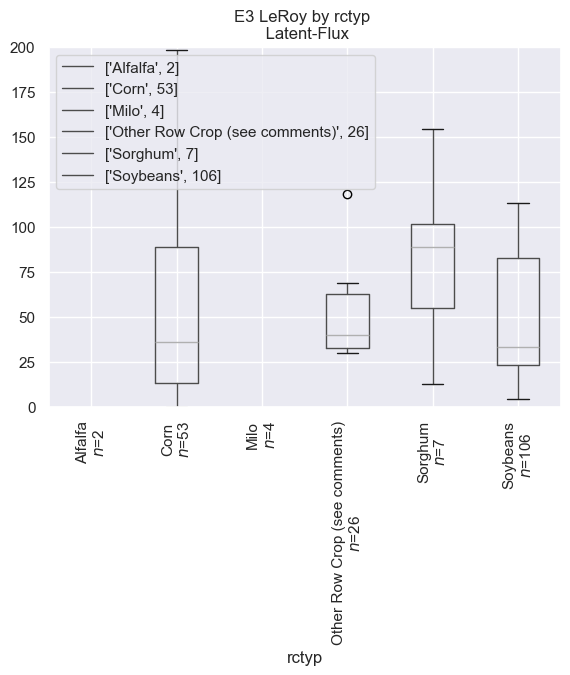

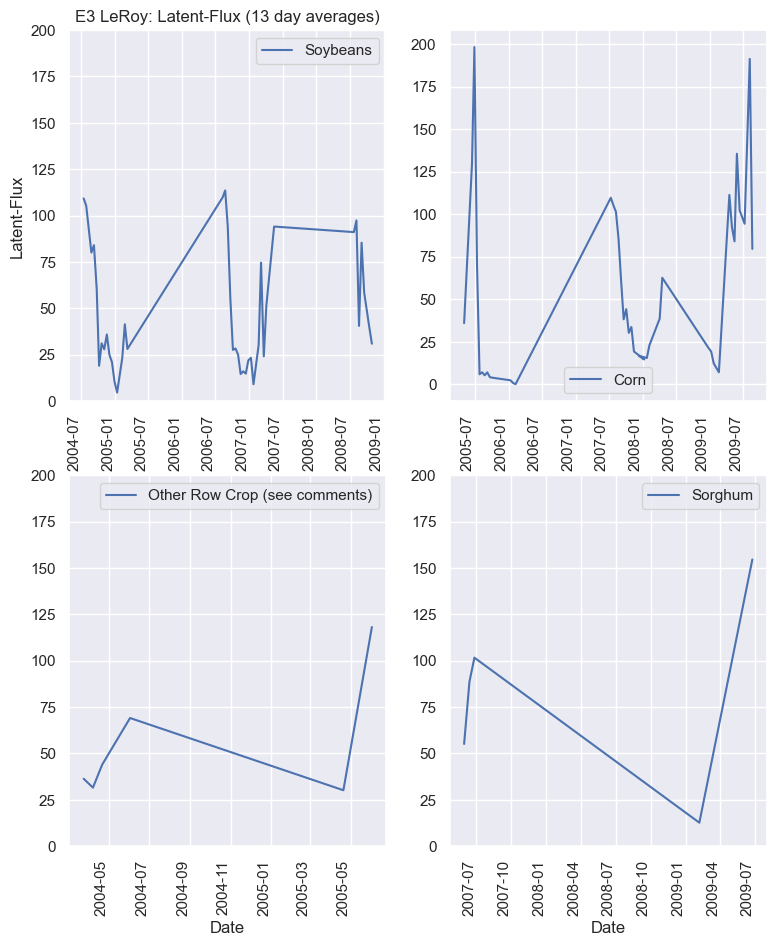

In [23]:
flux_type_1='Latent-Flux'
flux_type_2='CO2-Flux'
# group_type=['rowCropsTypeEc','rowCropsConditionEc']
group_type='rctyp'
sns.set_theme('notebook')

# fig,ax=plt.subplots(2,1,figsize=(4.5,6))
cax=site_conditions.boxplot(column=flux_type_1,by=group_type,rot=90)
# site_conditions.boxplot(column=flux_type_2,by=group_type,rot=90,ax=ax[1])
# plt.suptitle('');ax[0].set_xlabel('');ax[0].set_xticklabels('');ax[1].set_xlabel('')
plt.suptitle('');plt.ylim([0,200])
plt.title('{} by {} \n {}'.format(site,group_type,flux_type_1))
dfg = site_conditions.groupby(group_type);counts = [[k,len(v)] for k, v in dfg];plt.legend(counts)
cax.set_xticklabels(['%s\n$n$=%d'%(k, len(v)) for k, v in dfg])

fig,ax=plt.subplots(2,2,figsize=(9,12))
crop_1=site_conditions.rctyp.value_counts().index[0]
site_croptype_1=site_conditions[site_conditions['rctyp']==crop_1]
site_croptype_1=site_croptype_1.drop(site_croptype_1[np.isnan(site_croptype_1['Latent-Flux'])].index)
site_croptype_1.plot('Date',flux_type_1,rot=90,ax=ax[0,0])
ax[0,0].set_ylabel(flux_type_1);ax[0,0].legend([crop_1]);ax[0,0].set_ylim([0,200]);

if len(site_conditions.rctyp.value_counts())>1:
    crop_2=site_conditions.rctyp.value_counts().index[1]
    site_croptype_2=site_conditions[site_conditions['rctyp']==crop_2]
    site_croptype_2=site_croptype_2.drop(site_croptype_2[np.isnan(site_croptype_2['Latent-Flux'])].index)
    site_croptype_2.plot('Date',flux_type_1,rot=90,ax=ax[0,1])
    ax[0,1].legend([crop_2]);ax[1,0].set_ylim([0,200])

if len(site_conditions.rctyp.value_counts())>2:
    crop_3=site_conditions.rctyp.value_counts().index[2]
    site_croptype_3=site_conditions[site_conditions['rctyp']==crop_3]
    site_croptype_3=site_croptype_3.drop(site_croptype_3[np.isnan(site_croptype_3['Latent-Flux'])].index)
    site_croptype_3.plot('Date',flux_type_1,rot=90,ax=ax[1,0])
    ax[1,0].legend([crop_3]);ax[1,0].set_ylim([0,200]);

if len(site_conditions.rctyp.value_counts())>3:
    crop_4=site_conditions.rctyp.value_counts().index[3]
    site_croptype_4=site_conditions[site_conditions['rctyp']==crop_4]
    site_croptype_4=site_croptype_4.drop(site_croptype_4[np.isnan(site_croptype_4['Latent-Flux'])].index)
    site_croptype_4.plot('Date',flux_type_1,rot=90,ax=ax[1,1])
    ax[1,1].legend([crop_4]);ax[1,1].set_ylim([0,200])

ax[0,0].set_title('{}: {} ({} day averages)'.format(site,flux_type_1,interval))

# fig,ax=plt.subplots(1,2,figsize=(6,3))
# site_croptype_1.plot('time',flux_type_2,rot=90,ax=ax[0])
# site_croptype_2.plot('time',flux_type_2,rot=90,ax=ax[1])
# ax[0].set_ylabel(flux_type_2)
# ax[0].legend([crop_1]);ax[1].legend([crop_2])
# plt.suptitle('{}: {} ({} day averages)'.format(site,flux_type_2,interval))
# ax[0].set_ylim([-20,20]);ax[1].set_ylim([-20,20])

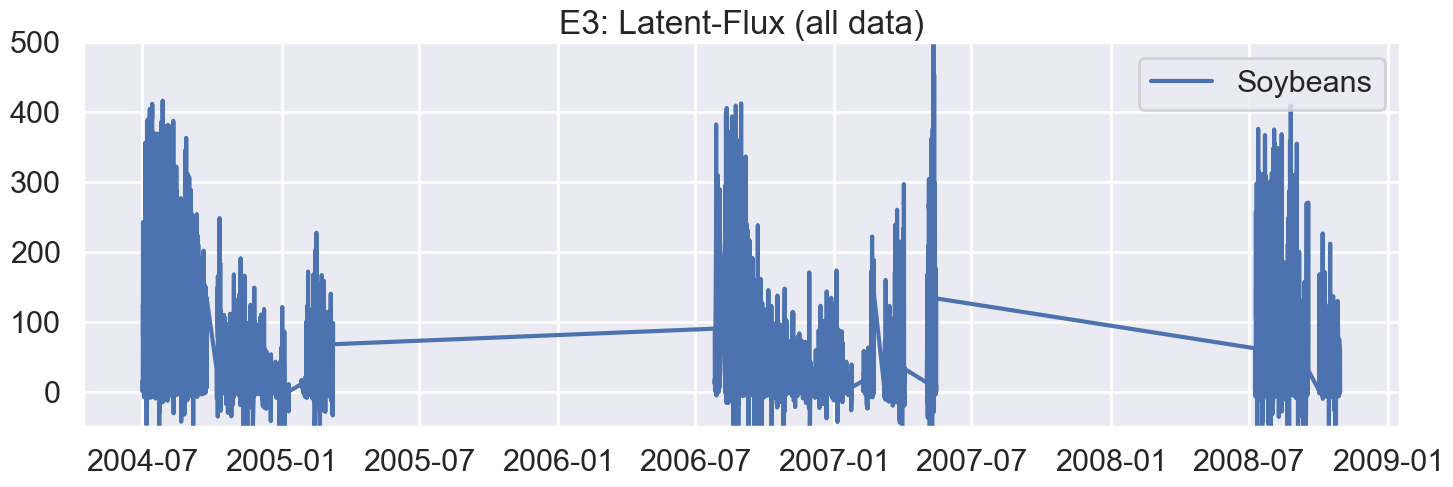

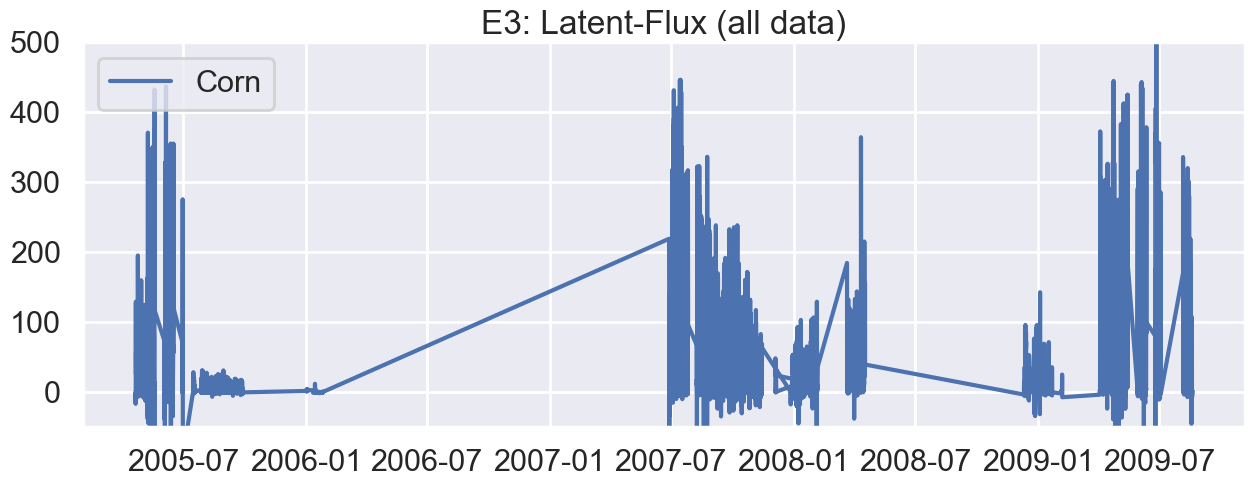

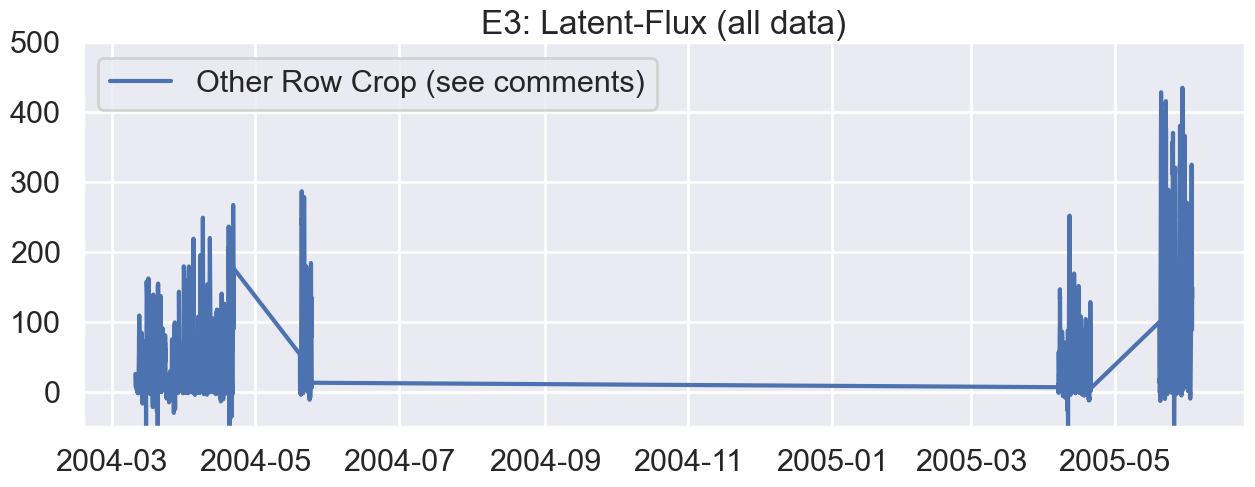

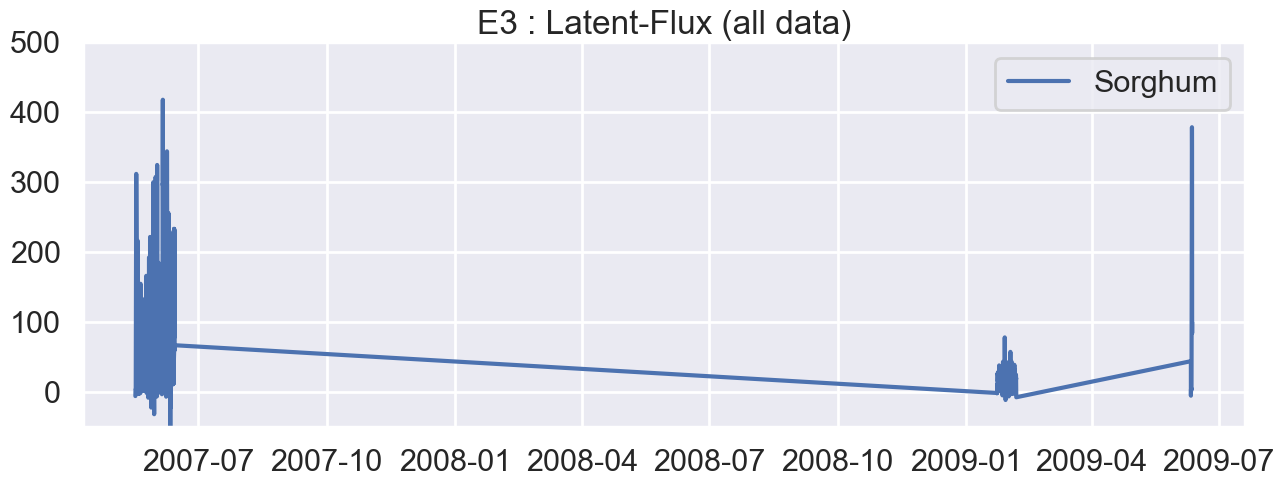

In [12]:
# del latent_flux_hourly_1
# del latent_flux_hourly_2
# del latent_flux_hourly_3
# del latent_flux_hourly_4
sns.set_theme('poster')

for k in range(0,len(site_croptype_1)): # len(site_croptype_1)
    if k==0:
        latent_flux_hourly_1=globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_1.Date.values)[k].strftime('%Y%m%d'))]
    else:
        latent_flux_hourly_1=xr.concat([latent_flux_hourly_1,globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_1.Date.values)[k].strftime('%Y%m%d'))]],'time')

fig,ax=plt.subplots(1,1,figsize=(17,5))
ax.plot(latent_flux_hourly_1.time,latent_flux_hourly_1)
ax.set_title('{}: {} (all data)'.format(sitename,flux_type_1,interval))
ax.set_ylim([-50,500]);ax.legend([crop_1])

if len(site_conditions.rctyp.value_counts())>1:
    for k in range(0,len(site_croptype_2)): # len(site_croptype_1)
        if k==0:
            latent_flux_hourly_2=globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_2.Date.values)[k].strftime('%Y%m%d'))]            
        else:
            latent_flux_hourly_2=xr.concat([latent_flux_hourly_2,globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_2.Date.values)[k].strftime('%Y%m%d'))]],'time')
    
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    ax.plot(latent_flux_hourly_2.time,latent_flux_hourly_2)
    ax.set_title('{}: {} (all data)'.format(sitename,flux_type_1,interval))
    ax.set_ylim([-50,500]);ax.legend([crop_2])
            
if len(site_conditions.rctyp.value_counts())>2:
    if len(site_croptype_3)>1:
        for k in range(0,len(site_croptype_3)): # len(site_croptype_1)
            if k==0:
                latent_flux_hourly_3=globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_3.Date.values)[k].strftime('%Y%m%d'))]
            else:
                latent_flux_hourly_3=xr.concat([latent_flux_hourly_3,globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_3.Date.values)[k].strftime('%Y%m%d'))]],'time')

        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(latent_flux_hourly_3.time,latent_flux_hourly_3)
        ax.set_title('{}: {} (all data)'.format(sitename,flux_type_1,interval))
        ax.set_ylim([-50,500]);ax.legend([crop_3])  

if len(site_conditions.rctyp.value_counts())>3:
    if len(site_croptype_4)>1:
        for k in range(0,len(site_croptype_4)): # len(site_croptype_1)
            if k==0:
                latent_flux_hourly_4=globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_4.Date.values)[k].strftime('%Y%m%d'))]
            else:
                latent_flux_hourly_4=xr.concat([latent_flux_hourly_4,globals()['latent_flux_biweekly_{}_{}'.format(sitename,pd.to_datetime(site_croptype_4.Date.values)[k].strftime('%Y%m%d'))]],'time')

        fig,ax=plt.subplots(1,1,figsize=(15,5))
        ax.plot(latent_flux_hourly_4.time,latent_flux_hourly_4)
        ax.set_title('{}: {} (all data)'.format(site[0:3],flux_type_1,interval))
        ax.set_ylim([-50,500]);ax.legend([crop_4])

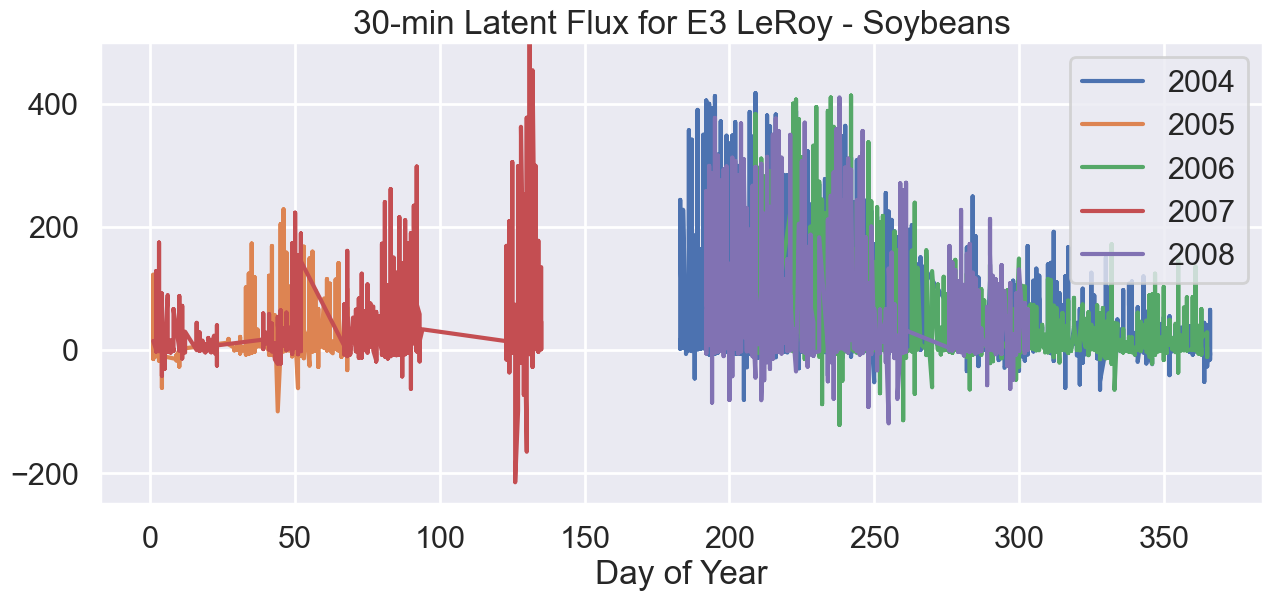

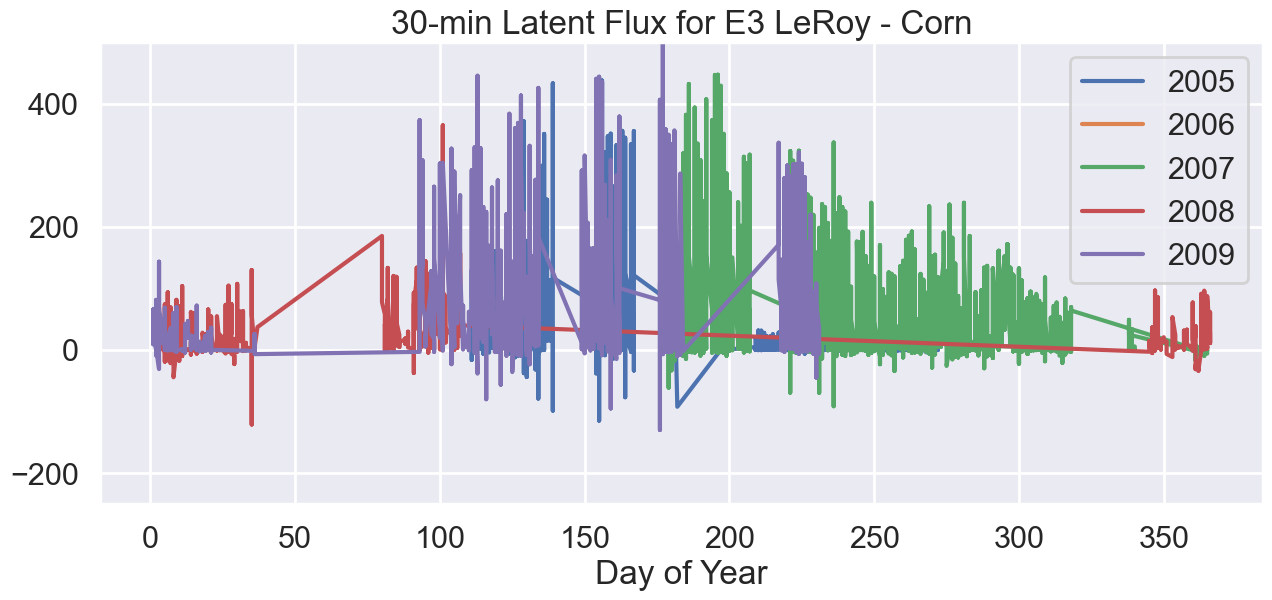

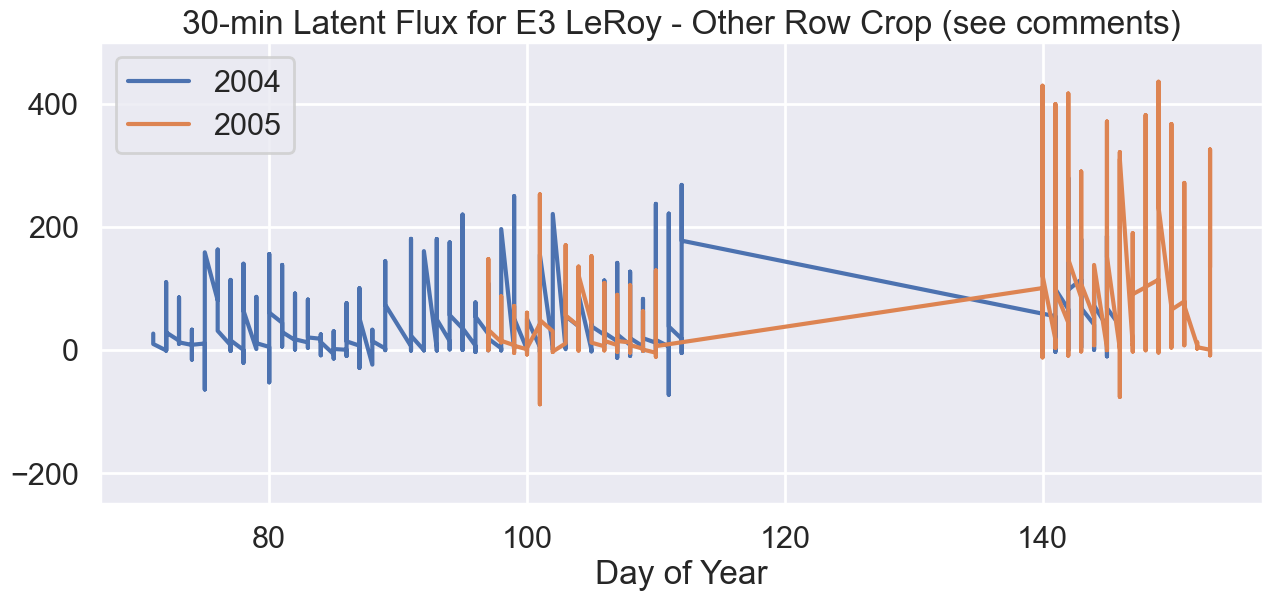

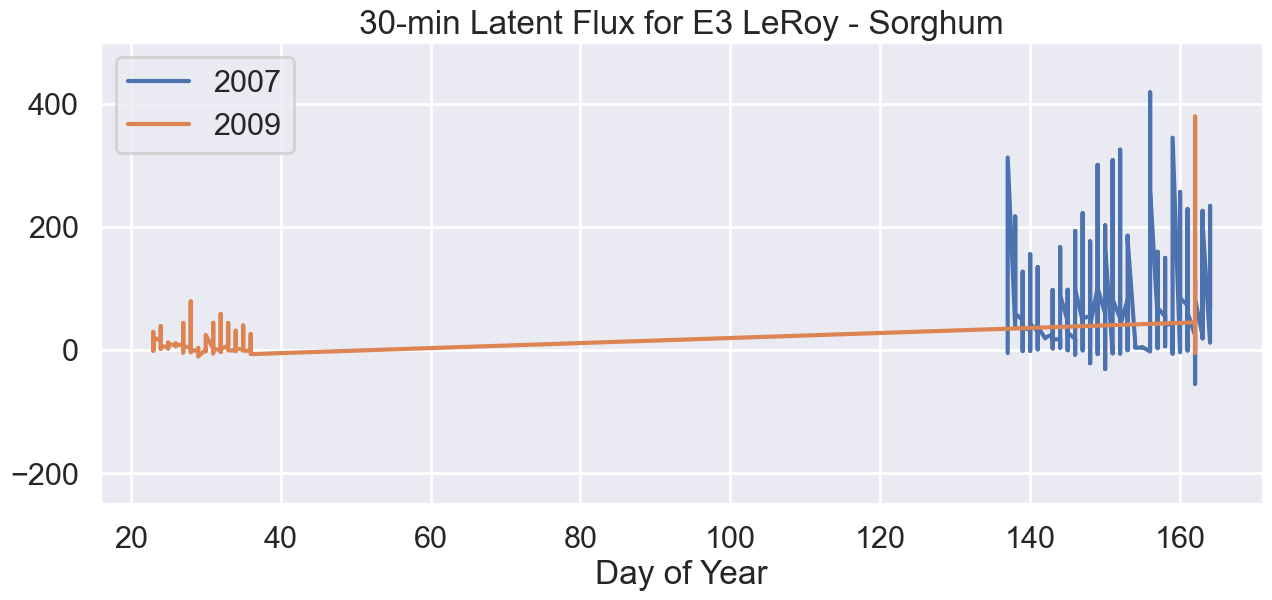

In [13]:
# plt.plot(latent_flux_hourly_1.time)
# plt.plot(latent_flux_hourly_1.time,latent_flux_hourly_1)
sns.set_theme('poster')

freq='30min' # 30min, daily, or monthly

fig,ax=plt.subplots(1,1,figsize=(15,6))
for k in range(0,len(list(latent_flux_hourly_1.groupby("time.year").groups))): # 
    globals()['year{}'.format(k)]=list(latent_flux_hourly_1.groupby("time.year").groups)[k]
    globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_1.groupby("time.year")[globals()['year{}'.format(k)]]
    globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
    globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
    if freq=='30min':
        plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
        plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_1))
    elif freq=='daily':
        plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
        plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_1))
    elif freq=='monthly':
        plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
        plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_1))    
    labels = [l for l in list(latent_flux_hourly_1.groupby("time.year").groups)]
    plt.legend(labels)
    plt.ylim([-250,500])
    

if len(site_conditions.rctyp.value_counts())>1:
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_2.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_2.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_2.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_2))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_2))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_2))    
        labels = [l for l in list(latent_flux_hourly_2.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])
        
if len(site_conditions.rctyp.value_counts())>2:        
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_3.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_3.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_3.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_3))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_3))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_3))    
        labels = [l for l in list(latent_flux_hourly_3.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])
        
if len(site_conditions.rctyp.value_counts())>3:        
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_4.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_4.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_4.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_4))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_4))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_4))    
        labels = [l for l in list(latent_flux_hourly_4.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])


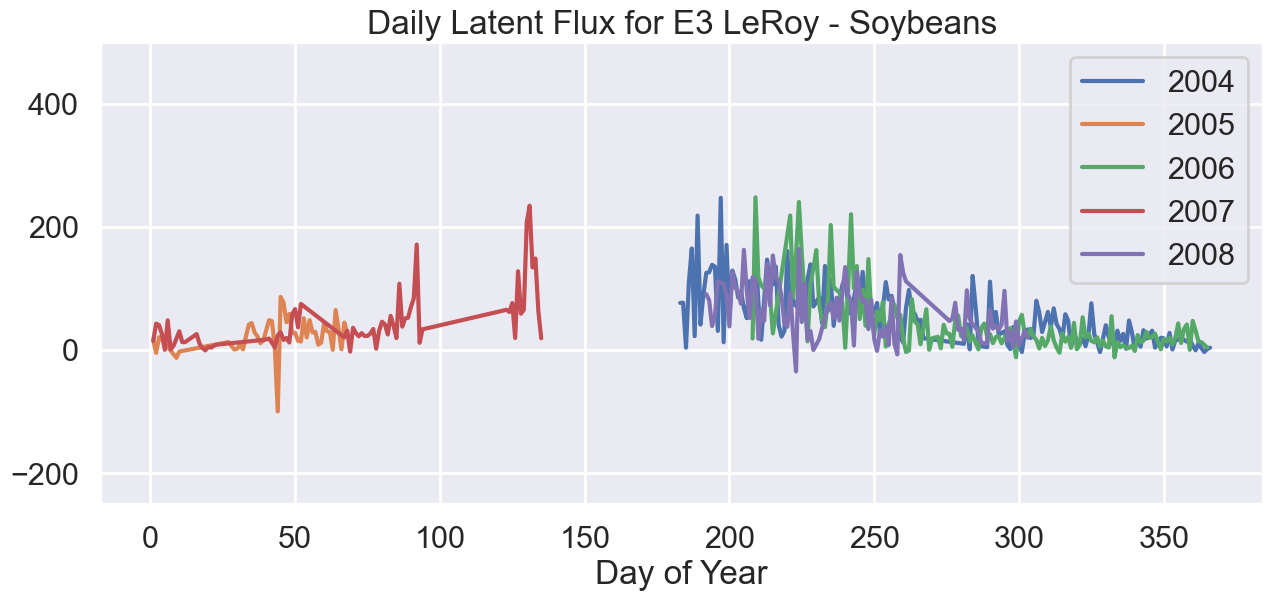

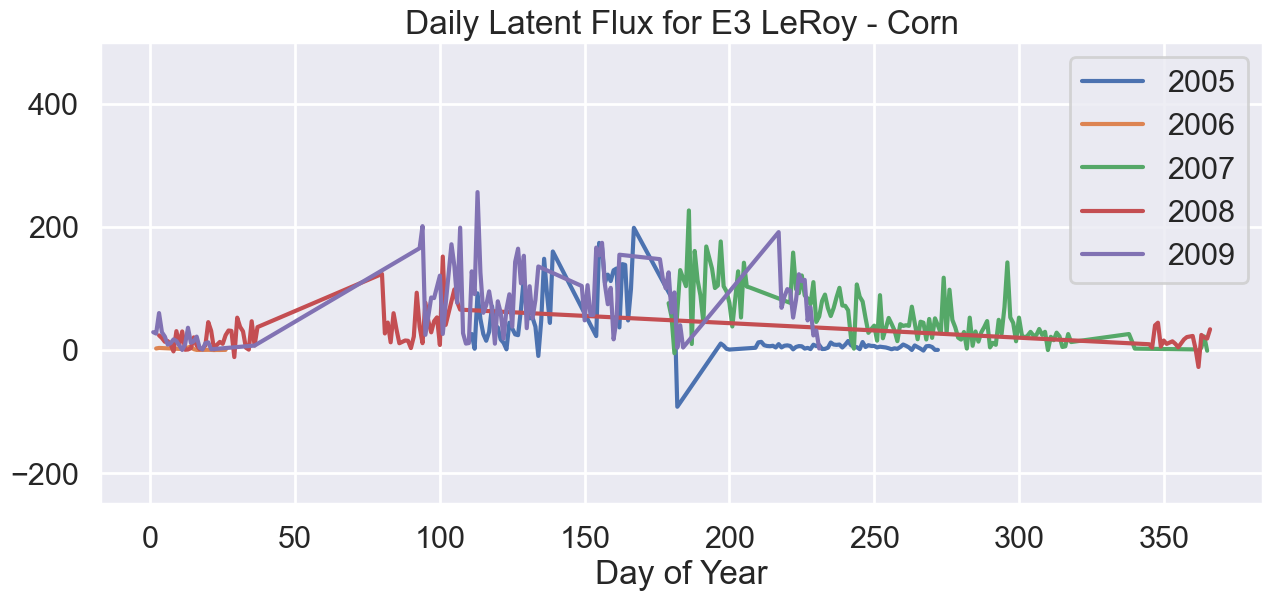

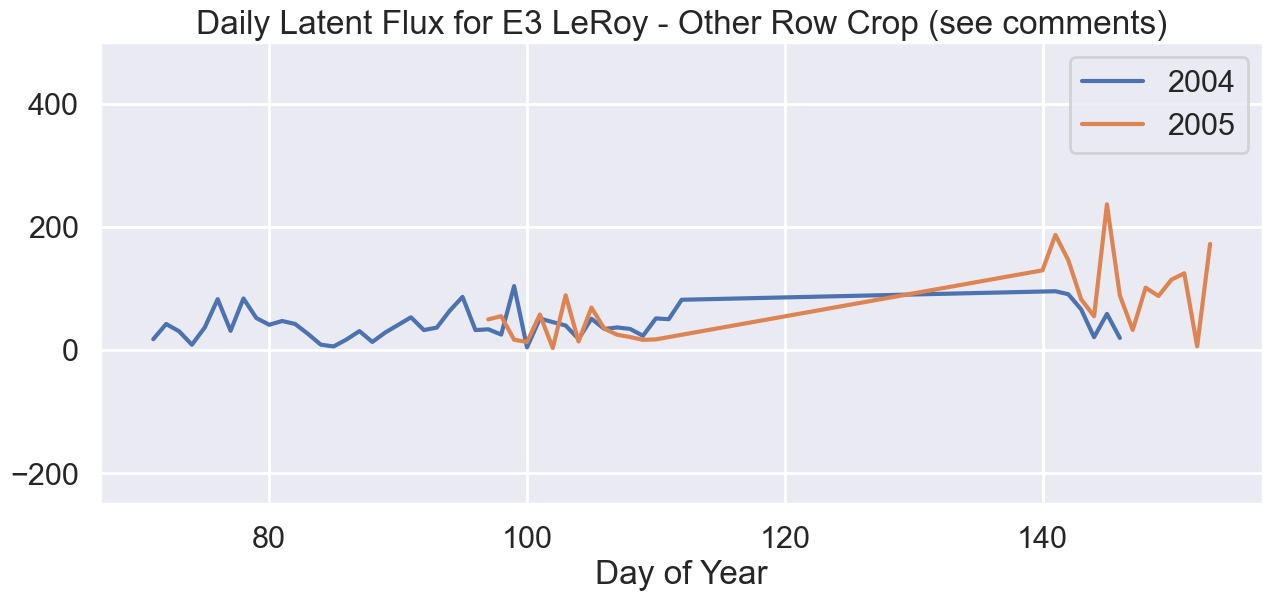

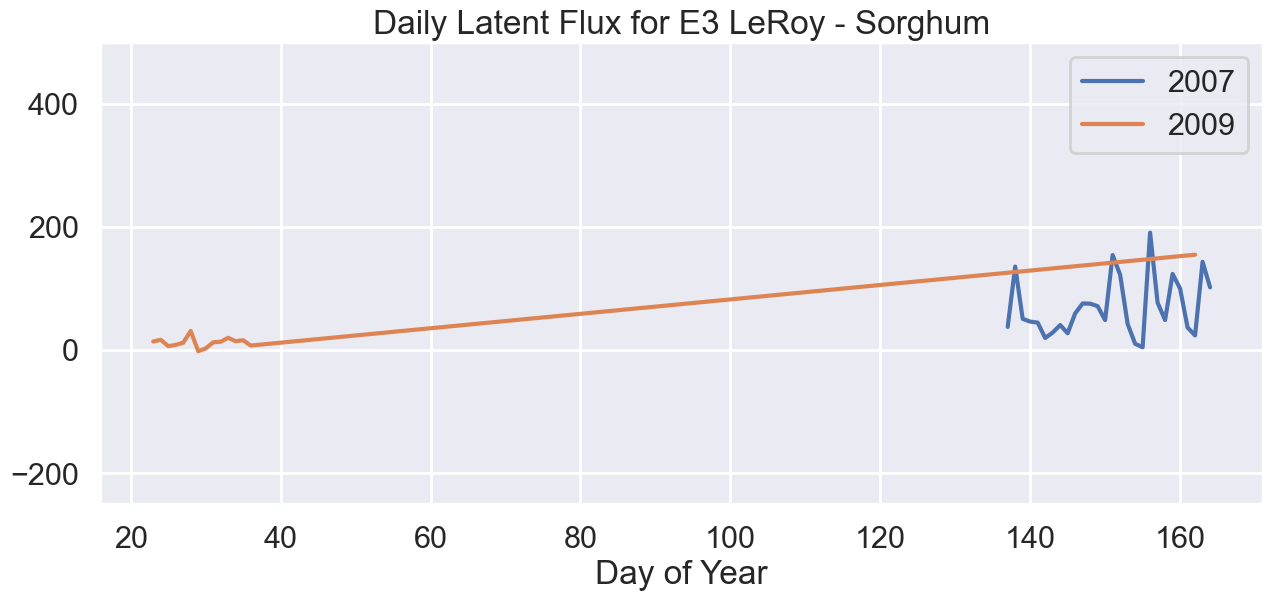

In [14]:
# plt.plot(latent_flux_hourly_1.time)
# plt.plot(latent_flux_hourly_1.time,latent_flux_hourly_1)
sns.set_theme('poster')

freq='daily' # 30min, daily, or monthly

fig,ax=plt.subplots(1,1,figsize=(15,6))
for k in range(0,len(list(latent_flux_hourly_1.groupby("time.year").groups))): # 
    globals()['year{}'.format(k)]=list(latent_flux_hourly_1.groupby("time.year").groups)[k]
    globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_1.groupby("time.year")[globals()['year{}'.format(k)]]
    globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
    globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
    if freq=='30min':
        plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
        plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_1))
    elif freq=='daily':
        plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
        plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_1))
    elif freq=='monthly':
        plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
        plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_1))    
    labels = [l for l in list(latent_flux_hourly_1.groupby("time.year").groups)]
    plt.legend(labels)
    plt.ylim([-250,500])
    

if len(site_conditions.rctyp.value_counts())>1:
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_2.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_2.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_2.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_2))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_2))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_2))    
        labels = [l for l in list(latent_flux_hourly_2.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])
        
if len(site_conditions.rctyp.value_counts())>2:        
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_3.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_3.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_3.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_3))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_3))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_3))    
        labels = [l for l in list(latent_flux_hourly_3.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])
        
if len(site_conditions.rctyp.value_counts())>3:        
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_4.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_4.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_4.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_4))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_4))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_4))    
        labels = [l for l in list(latent_flux_hourly_4.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])


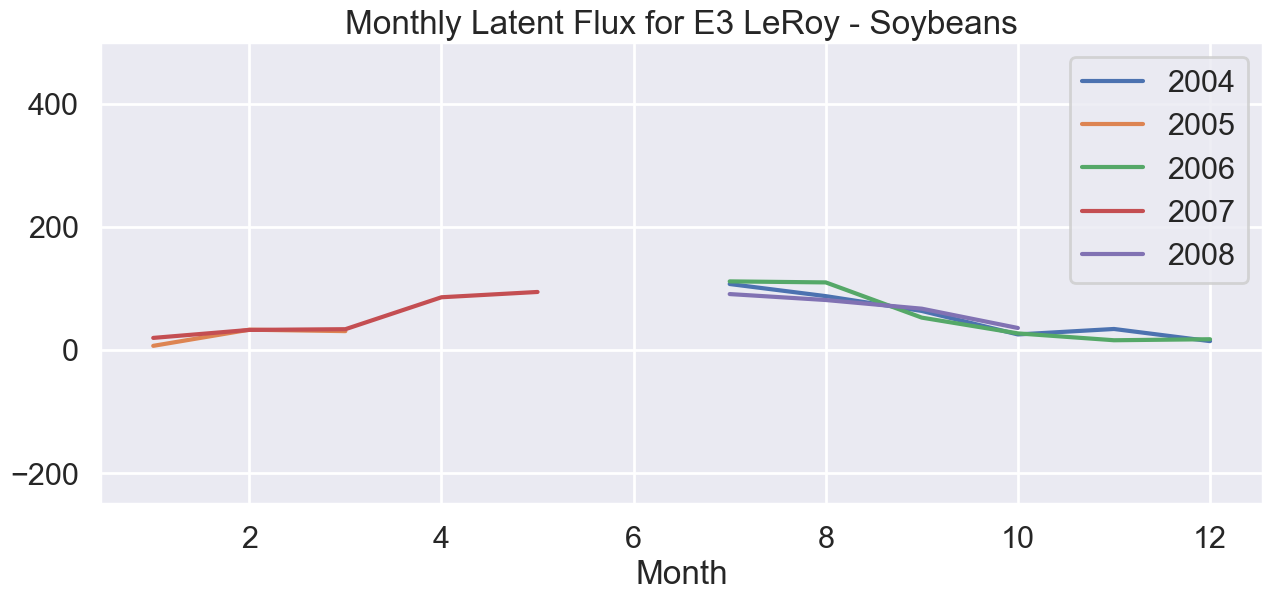

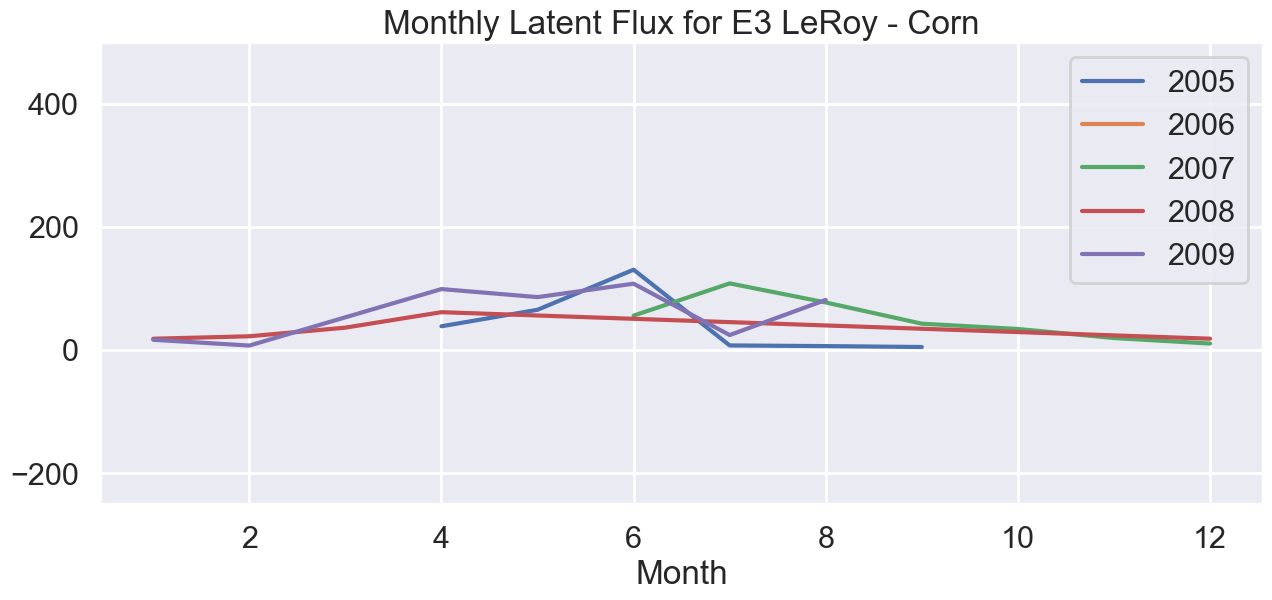

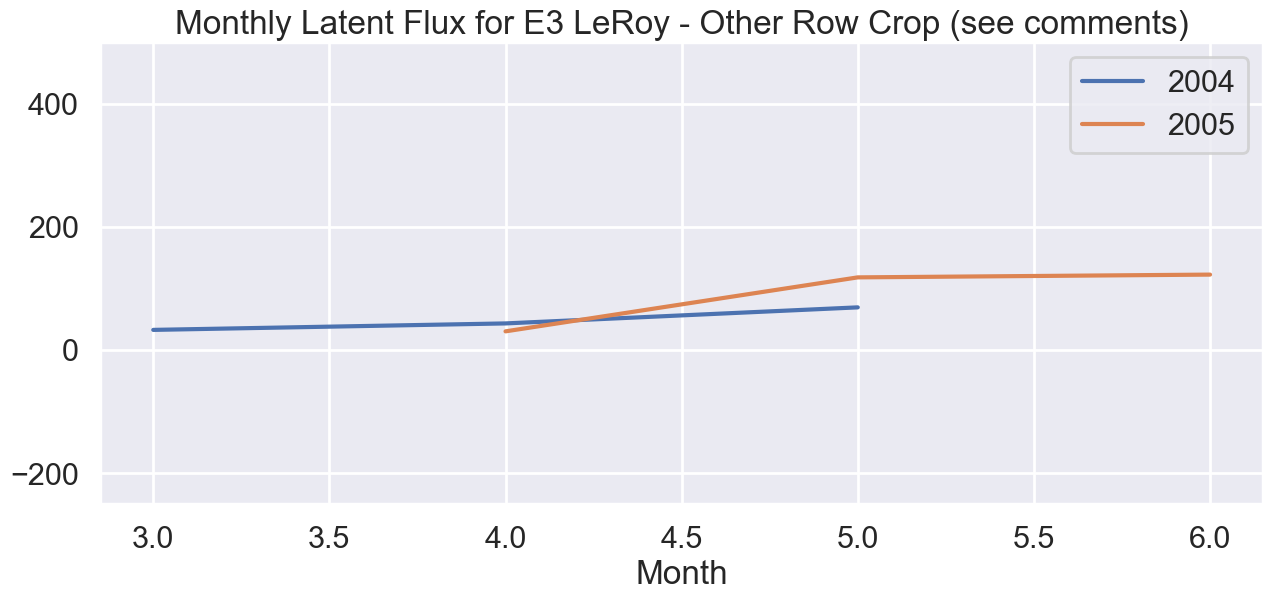

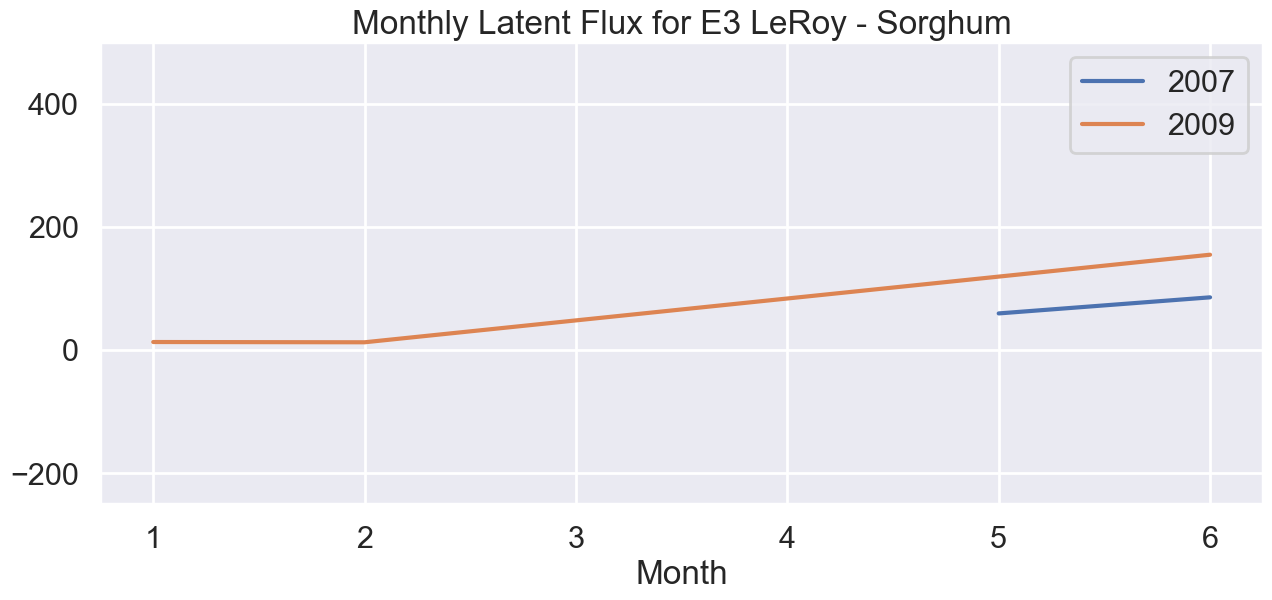

In [15]:
# plt.plot(latent_flux_hourly_1.time)
# plt.plot(latent_flux_hourly_1.time,latent_flux_hourly_1)
sns.set_theme('poster')

freq='monthly' # 30min, daily, or monthly

fig,ax=plt.subplots(1,1,figsize=(15,6))
for k in range(0,len(list(latent_flux_hourly_1.groupby("time.year").groups))): # 
    globals()['year{}'.format(k)]=list(latent_flux_hourly_1.groupby("time.year").groups)[k]
    globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_1.groupby("time.year")[globals()['year{}'.format(k)]]
    globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
    globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
    if freq=='30min':
        plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
        plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_1))
    elif freq=='daily':
        plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
        plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_1))
    elif freq=='monthly':
        plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
        plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_1))    
    labels = [l for l in list(latent_flux_hourly_1.groupby("time.year").groups)]
    plt.legend(labels)
    plt.ylim([-250,500])
    

if len(site_conditions.rctyp.value_counts())>1:
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_2.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_2.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_2.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_2))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_2))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_2))    
        labels = [l for l in list(latent_flux_hourly_2.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])
        
if len(site_conditions.rctyp.value_counts())>2:        
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_3.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_3.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_3.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_3))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_3))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_3))    
        labels = [l for l in list(latent_flux_hourly_3.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])
        
if len(site_conditions.rctyp.value_counts())>3:        
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    for k in range(0,len(list(latent_flux_hourly_4.groupby("time.year").groups))): # 
        globals()['year{}'.format(k)]=list(latent_flux_hourly_4.groupby("time.year").groups)[k]
        globals()['latent_flux_year{}'.format(k)]=latent_flux_hourly_4.groupby("time.year")[globals()['year{}'.format(k)]]
        globals()['latent_flux_year{}_daily'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.dayofyear").mean()
        globals()['latent_flux_year{}_monthly'.format(k)]=globals()['latent_flux_year{}'.format(k)].groupby("time.month").mean()
        if freq=='30min':
            plt.plot(globals()['latent_flux_year{}'.format(k)]['time.dayofyear'],globals()['latent_flux_year{}'.format(k)])
            plt.xlabel('Day of Year');plt.title('30-min Latent Flux for {} - {}'.format(site,crop_4))
        elif freq=='daily':
            plt.plot(globals()['latent_flux_year{}_daily'.format(k)]['dayofyear'],globals()['latent_flux_year{}_daily'.format(k)])
            plt.xlabel('Day of Year');plt.title('Daily Latent Flux for {} - {}'.format(site,crop_4))
        elif freq=='monthly':
            plt.plot(globals()['latent_flux_year{}_monthly'.format(k)]['month'],globals()['latent_flux_year{}_monthly'.format(k)])
            plt.xlabel('Month');plt.title('Monthly Latent Flux for {} - {}'.format(site,crop_4))    
        labels = [l for l in list(latent_flux_hourly_4.groupby("time.year").groups)]
        plt.legend(labels)
        plt.ylim([-250,500])


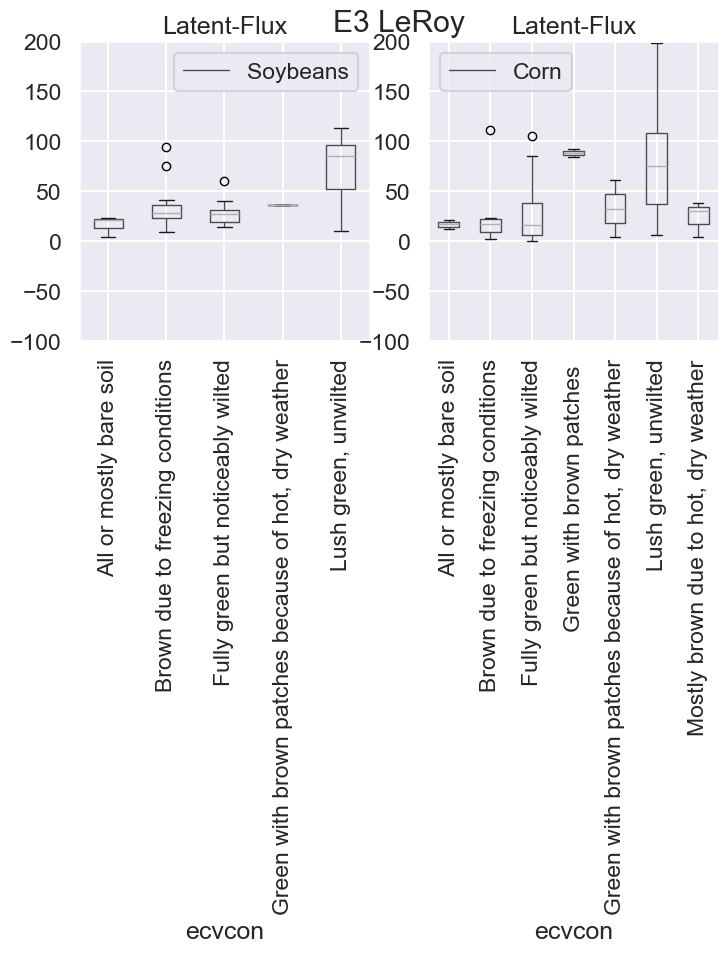

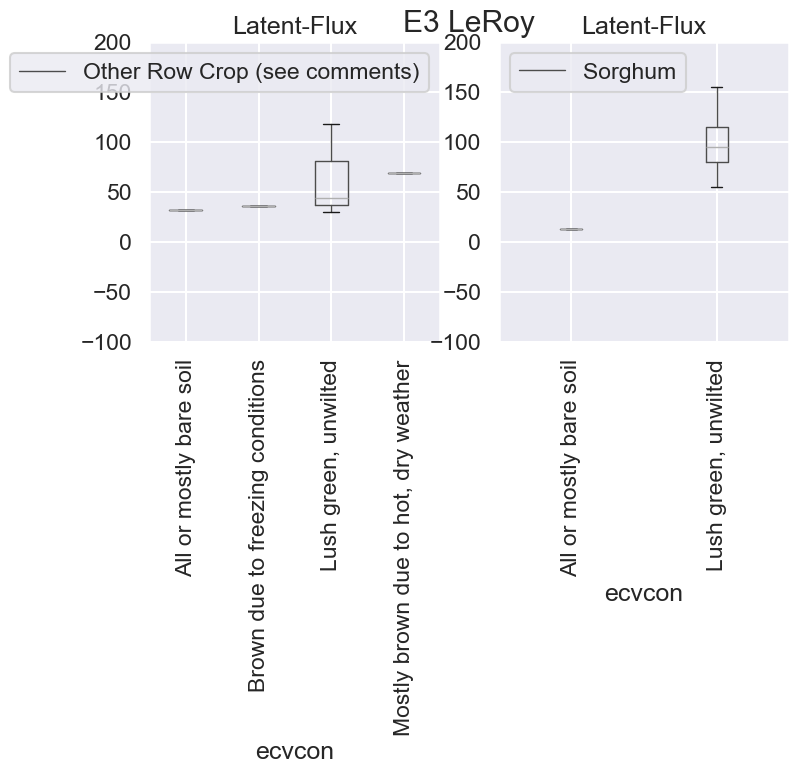

In [16]:
flux_type_1='Latent-Flux'
group_type='ecvcon'
sns.set_theme('talk')

fig,ax=plt.subplots(1,2,figsize=(8,4))
site_croptype_1.boxplot(column=flux_type_1,by=group_type,rot=90,ax=ax[0])
plt.suptitle('')
ax[0].set_ylim([-100,200]);ax[0].legend([crop_1])

if len(site_conditions.rctyp.value_counts())>1:
    site_croptype_2.boxplot(column=flux_type_1,by=group_type,rot=90,ax=ax[1])
    plt.suptitle('')
    ax[1].set_ylim([-100,200]);ax[1].legend([crop_2])
    plt.suptitle('{}'.format(site));
    
fig,ax=plt.subplots(1,2,figsize=(8,4))
if len(site_conditions.rctyp.value_counts())>2:
    site_croptype_3.boxplot(column=flux_type_1,by=group_type,rot=90,ax=ax[0])
    plt.suptitle('')
    ax[0].set_ylim([-100,200]);ax[0].legend([crop_3])
    plt.suptitle('{}'.format(site));
    
if len(site_conditions.rctyp.value_counts())>3:
    site_croptype_4.boxplot(column=flux_type_1,by=group_type,rot=90,ax=ax[1])
    plt.suptitle('')
    ax[1].set_ylim([-100,200]);ax[1].legend([crop_4])
    plt.suptitle('{}'.format(site));